# Tutorial 06: Normalizing Flows for image modeling

**Topics of this tutorial:**
- General structure of normalizing flows
- How to deal with discrete input variables (like images with RGB values from 0-255)
- Different types of normalizing flow layers
- Play with a pre-trained diffuser model

In [ ]:
#@title Code: imports

## Standard libraries
import os
import math
import time
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-1-91df27f698ef>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


## Normalizing Flows as generative model

**A overview of generative models:**

(figure credit - [Lilian Weng](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial11/comparison_GAN_VAE_NF.png?raw=1" width="600px"></center>

**How to model a probability density with an invertible function?**

The change of variables formula. Specifically, given a prior density $p_z(z)$ (e.g. Gaussian) and an invertible function $f$, we can determine $p_x(x)$ as follows:

$$
\begin{split}
    \int p_x(x) dx & = \int p_z(z) dz = 1 \hspace{1cm}\text{(by definition of a probability distribution)}\\
    \Leftrightarrow p_x(x) & = p_z(z) \left|\frac{dz}{dx}\right| = p_z(f(x)) \left|\frac{df(x)}{dx}\right|
\end{split}
$$

In the multivariate case, we have:

$$
\log p_x(\mathbf{x}) = \log p_z(f(\mathbf{x})) + \log{} \left|\det \frac{df(\mathbf{x})}{d\mathbf{x}}\right|
$$

Note that we take logarithms on both side since we are mostly interested in the log-evidence.

**An intuitive example of normalizing flow in 1d**:

Assume we have a simple prior probability density $p(x)$ (e.g., a uniform distribution), after applying a scaling transformation : $y=f(x)=2x+1$, we will observe some change on the volume of the probability density, as illustrated below (figure credit - [Eric Jang](https://blog.evjang.com/2018/01/nf1.html)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial11/uniform_flow.png?raw=1" width="300px"></center>

This change in volume represents $\left|\frac{df(x)}{dx}\right|$ in our equation above, and ensures that even after scaling, we still have a valid probability distribution.

**How could we make $f$ even more expressive without making it to hard to compute the inverse?**

Stack multiple invertible functions $f_{1,...,K}$ after each other, as all together, they still represent **a single, invertible function**.

Intuitively, by using multiple, learnable invertible functions, a normalizing flow attempts to transform $p_z(z)$ **slowly** into a more complex distribution which should finally be $p_x(x)$. We visualize the idea below
(figure credit - [Lilian Weng](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial11/normalizing_flow_layout.png?raw=1" width="700px"></center>

<!-- Starting from $z_0$, which follows the prior Gaussian distribution, we sequentially apply the invertible functions $f_1,f_2,...,f_K$, until $z_K$ represents $x$. Note that in the figure above, the functions $f$ represent the inverted function from $f$ we had above (here: $f:Z\to X$, above: $f:X\to Z$). This is just a different notation and has no impact on the actual flow design because all $f$ need to be invertible anyways. When we estimate the log likelihood of a data point $x$ as in the equations above, we run the flows in the opposite direction than visualized above. Multiple flow layers have been proposed that use a neural network as learnable parameters, such as the planar and radial flow. However, we will focus here on flows that are commonly used in image modeling, and will discuss them in the rest of the notebook along with the details of how to train a normalizing flow. -->

## Normalizing Flows on images

**Task: maps an input image (MNIST) to an equally sized latent space**

<center width="100%" style="padding: 10px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial11/image_to_gaussian.svg?raw=1" width="450px"></center>

**Standar evaluation metric for NFs: bits per dimension**

Bits per dimensions (bpd) is motivated from an information theory perspective and describes how many bits we would need to encode a particular example in our modeled distribution. The less bits we need, the more likely the example in our distribution.

In order to calculate the bits per dimension score, we can rely on the negative log-likelihood and change the log base (as bits are binary while NLL is usually exponential):

$$\text{bpd} = \text{nll} \cdot \log_2\left(\exp(1)\right) \cdot \left(\prod d_i\right)^{-1}$$

where $d_1,...,d_K$ are the dimensions of the input. For images, this would be the height, width and channel number.

## A general model structure of normalizing flows for images

In [ ]:
#@title Code: ImageFlow

class ImageFlow(pl.LightningModule):

    def __init__(self, flows, import_samples=8):
        """
        Inputs:
            flows - A list of flows (each a nn.Module) that should be applied on the images.
            import_samples - Number of importance samples to use during testing (see explanation below). Can be changed at any time
        """
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.import_samples = import_samples
        # Create prior distribution for final latent space
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)

    def forward(self, imgs):
        # The forward function is only used for visualizing the graph
        return self._get_likelihood(imgs)

    def encode(self, imgs):
        # Given a batch of images, return the latent representation z and ldj of the transformations
        z, ldj = imgs, torch.zeros(imgs.shape[0], device=self.device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj

    def _get_likelihood(self, imgs, return_ll=False):
        """
        Given a batch of images, return the likelihood of those.
        If return_ll is True, this function returns the log likelihood of the input.
        Otherwise, the ouptut metric is bits per dimension (scaled negative log likelihood)
        """
        z, ldj = self.encode(imgs)
        log_pz = self.prior.log_prob(z).sum(dim=[1,2,3])
        log_px = ldj + log_pz
        nll = -log_px
        # Calculating bits per dimension
        bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
        return bpd.mean() if not return_ll else log_px

    @torch.no_grad()
    def sample(self, img_shape, z_init=None):
        """
        Sample a batch of images from the flow.
        """
        # Sample latent representation from prior
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)

        # Transform z to x by inverting the flows
        ldj = torch.zeros(img_shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # A scheduler is optional, but can help in flows to get the last bpd improvement
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # Normalizing flows are trained by maximum likelihood => return bpd
        loss = self._get_likelihood(batch[0])
        self.log('train_bpd', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_likelihood(batch[0])
        self.log('val_bpd', loss)

    def test_step(self, batch, batch_idx):
        # Perform importance sampling during testing => estimate likelihood M times for each image
        samples = []
        for _ in range(self.import_samples):
            img_ll = self._get_likelihood(batch[0], return_ll=True)
            samples.append(img_ll)
        img_ll = torch.stack(samples, dim=-1)

        # To average the probabilities, we need to go from log-space to exp, and back to log.
        # Logsumexp provides us a stable implementation for this
        img_ll = torch.logsumexp(img_ll, dim=-1) - np.log(self.import_samples)

        # Calculate final bpd
        bpd = -img_ll * np.log2(np.exp(1)) / np.prod(batch[0].shape[1:])
        bpd = bpd.mean()

        self.log('test_bpd', bpd)

The `test_step` function differs from the training and validation step in that it makes use of importance sampling. We will discuss the motiviation and details behind this after understanding how flows model discrete images in continuous space.

### Dequantization

Normalizing flows rely on the rule of change of variables, which is naturally defined in **continuous** space. Applying flows directly on discrete data leads to undesired density models where arbitrarily high likelihood are placed on a few, particular values. See the illustration below:

<center><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial11/dequantization_issue.svg?raw=1" width="40%"/></center>

**How to make discrete variables "continuous"?**

Add a small amount of noise to each discrete value --> **dequantization**.

Considering $x$ as an integer (as it is the case for images), the dequantized representation $v$ can be formulated as $v=x+u$ where $u\in[0,1)^D$. Our objective of modeling $p(x)$ becomes:

$$ p(x) = \int p(x+u)du = \int \frac{q(u|x)}{q(u|x)}p(x+u)du = \mathbb{E}_{u\sim q(u|x)}\left[\frac{p(x+u)}{q(u|x)} \right]$$

with $q(u|x)$ being the noise distribution. For now, we assume it to be uniform, which can also be written as $p(x)=\mathbb{E}_{u\sim U(0,1)^D}\left[p(x+u) \right]$.

**Example with uniform prior**

<center><img src="https://github.com/CausalLearningAI/applied-dl-tutorials/blob/main/t06/imgs/dequantization.png?raw=1" width="50%"/></center>


In [ ]:
#@title Code: Dequantization

class Dequantization(nn.Module):

    def __init__(self, alpha=1e-5, quants=256):
        """
        Inputs:
            alpha - small constant that is used to scale the original input.
                    Prevents dealing with values very close to 0 and 1 when inverting the sigmoid
            quants - Number of possible discrete values (usually 256 for 8-bit image)
        """
        super().__init__()
        self.alpha = alpha
        self.quants = quants

    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            ldj += np.log(self.quants) * np.prod(z.shape[1:])
            z = torch.floor(z).clamp(min=0, max=self.quants-1).to(torch.int32)
        return z, ldj

    def sigmoid(self, z, ldj, reverse=False):
        # Applies an invertible sigmoid transformation
        if not reverse:
            ldj += (-z-2*F.softplus(-z)).sum(dim=[1,2,3])
            z = torch.sigmoid(z)
            # Reversing scaling for numerical stability
            ldj -= np.log(1 - self.alpha) * np.prod(z.shape[1:])
            z = (z - 0.5 * self.alpha) / (1 - self.alpha)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha  # Scale to prevent boundaries 0 and 1
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-torch.log(z) - torch.log(1-z)).sum(dim=[1,2,3])
            z = torch.log(z) - torch.log(1-z)
        return z, ldj

    def dequant(self, z, ldj):
        # Transform discrete values to continuous volumes
        z = z.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj

### Variational dequantization

**Potential issue: What if the prior is not uniform but some other categorial distribution?**

<center><img src="https://github.com/CausalLearningAI/applied-dl-tutorials/blob/main/t06/imgs/issue_dequant.png?raw=1" width="50%"/></center>


**Solution: learn $q(u|x)$ --> variational quantization**



In [ ]:
#@title Code: VariationalDequantization
class VariationalDequantization(Dequantization):

    def __init__(self, var_flows, alpha=1e-5):
        """
        Inputs:
            var_flows - A list of flow transformations to use for modeling q(u|x)
            alpha - Small constant, see Dequantization for details
        """
        super().__init__(alpha=alpha)
        self.flows = nn.ModuleList(var_flows)

    def dequant(self, z, ldj):
        z = z.to(torch.float32)
        img = (z / 255.0) * 2 - 1 # We condition the flows on x, i.e. the original image

        # Prior of u is a uniform distribution as before
        # As most flow transformations are defined on [-infinity,+infinity], we apply an inverse sigmoid first.
        deq_noise = torch.rand_like(z).detach()
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=True)
        for flow in self.flows:
            deq_noise, ldj = flow(deq_noise, ldj, reverse=False, orig_img=img)
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=False)

        # After the flows, apply u as in standard dequantization
        z = (z + deq_noise) / 256.0
        ldj -= np.log(256.0) * np.prod(z.shape[1:])
        return z, ldj

### Coupling layers


<center width="100%" style="padding: 10px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial11/coupling_flow.svg?raw=1" width="450px"></center>


In [ ]:
#@title Code: CouplingLayer
class CouplingLayer(nn.Module):

    def __init__(self, network, mask, c_in):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in - Number of input channels
        """
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
        # Register mask as buffer as it is a tensor which is not a parameter,
        # but should be part of the modules state.
        self.register_buffer('mask', mask)

    def forward(self, z, ldj, reverse=False, orig_img=None):
        """
        Inputs:
            z - Latent input to the flow
            ldj - The current ldj of the previous flows.
                  The ldj of this layer will be added to this tensor.
            reverse - If True, we apply the inverse of the layer.
            orig_img (optional) - Only needed in VarDeq. Allows external
                                  input to condition the flow on (e.g. original image)
        """
        # Apply network to masked input
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)

        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac

        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1,2,3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1,2,3])

        return z, ldj

### Hierarchical coupling

To make the normalizing flows more expressive, in practice, we usually apply a **recursive** form of coupling.

We formalize a single coupling $f_C$ as

$$
z^\prime = f_C(z) = \begin{bmatrix}z_1 \\ C(z_2 | z_1)\end{bmatrix} = \begin{bmatrix}z_1^\prime \\ z_2^\prime \end{bmatrix}
$$

A recursive coupling block with a hierarchy depth $K$ will take the form:

$$
z^\prime = f_{R, k}(z) = \begin{cases}f_C(z), & \text{if} N_k \leq 3 \\
\begin{bmatrix}f_{R, k-1}(z_1) \\ C_k\left(f_{R, k-1}(z_2) | z_1\right)\end{bmatrix}, & \text{else} \end{cases}
$$

with $k = K, K-1, \dots, 1$

Here is an illustrative example to show why we want to have recursive blocks:

<center><img src="https://github.com/CausalLearningAI/applied-dl-tutorials/blob/main/t06/imgs/motivation_h_coupling.png?raw=1" width="50%"></center>

Intuitively, by adding recursions in the coupling blocks, we are filling the lower triangular part of the jacobian matrix with smaller non-zero rectangles. A jacobian with more non-zero elements means there are more dependencies between the input $z$ (or $x$ in the figure) and output $f(z)$ (or $f(x)$).

In other words, the more complicated the jacobian is, the more complicated the transformation $f$ will be, so the normalizing flow becomes more expressive.




**Structure overview of a hierarchical coupling block**:
<center><img src="https://github.com/CausalLearningAI/applied-dl-tutorials/blob/main/t06/imgs/h_coupling.png?raw=1" width="60%"></center>


<center><img src="https://github.com/CausalLearningAI/applied-dl-tutorials/blob/main/t06/imgs/hierarchical_coupling_flow.svg?raw=1" width="60%"></center>

In [ ]:
#@title Code: Hierarchical Coupling (HINT)

# https://github.com/vislearn/HINT/blob/master/hint.py
!pip install FrEIA
from math import exp

import torch
import torch.nn as nn

from FrEIA.modules.orthogonal import HouseholderPerm


def linear_subnet_constructor(c_in, c_out, c_internal):
    return nn.Sequential(
        nn.Linear(c_in, c_internal),
        nn.ReLU(),
        nn.Linear(c_internal, c_internal),
        nn.ReLU(),
        nn.Linear(c_internal, c_out),
    )


def conv_subnet_constructor(c_in, c_out, c_internal):
    return nn.Sequential(
        nn.Conv2d(c_in, c_internal, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(c_internal, c_internal, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(c_internal, c_out, 3, padding=1),
    )


class HierarchicalAffineCouplingTree(nn.Module):

    def __init__(
        self,
        data_shape,
        dims_c,
        conv=False,
        subnet_constructor=None,
        c_internal=[],
        clamp=2,
        max_splits=-1,
        min_split_size=2,
        reshuffle=False,
    ):
        super().__init__()
        self.data_shape = data_shape
        self.clamp = clamp
        if subnet_constructor is None:
            subnet_constructor = (
                conv_subnet_constructor if conv else linear_subnet_constructor
            )
        if len(c_internal) == 0:
            c_internal = [
                data_shape[0],
            ]
        if len(c_internal) == 1:
            c_internal += c_internal

        if reshuffle:
            self.perm = HouseholderPerm(
                [data_shape], dims_c=dims_c, n_reflections=data_shape[0], fixed=True
            )
        else:
            self.perm = None

        self.split_idx = data_shape[0] // 2
        self.conditional = len(dims_c) > 0
        condition_length = sum([dims_c[i][0] for i in range(len(dims_c))])
        self.s = subnet_constructor(
            self.split_idx + condition_length,
            data_shape[0] - self.split_idx,
            c_internal[0],
        )
        self.t = subnet_constructor(
            self.split_idx + condition_length,
            data_shape[0] - self.split_idx,
            c_internal[0],
        )

        if data_shape[0] >= 2 * min_split_size and max_splits != 0:
            self.leaf = False
            self.upper = HierarchicalAffineCouplingTree(
                (self.split_idx,) + data_shape[1:],
                dims_c,
                conv,
                subnet_constructor,
                c_internal[1:],
                clamp,
                max_splits - 1,
                min_split_size,
                reshuffle,
            )
            self.lower = HierarchicalAffineCouplingTree(
                (data_shape[0] - self.split_idx,) + data_shape[1:],
                dims_c,
                conv,
                subnet_constructor,
                c_internal[1:],
                clamp,
                max_splits - 1,
                min_split_size,
                reshuffle,
            )
        else:
            self.leaf = True

    def e(self, s):
        return torch.exp(self.clamp * 0.636 * torch.atan(s))

    def log_e(self, s):
        """log of the nonlinear function e"""
        return self.clamp * 0.636 * torch.atan(s)

    def forward(self, x, c=[], rev=False):
        # Potentially reshuffle
        if not rev and self.perm is not None:
            x = self.perm([x])[0]

        # Split data lanes
        x_upper, x_lower = torch.split(
            x, [self.split_idx, x.shape[1] - self.split_idx], dim=1
        )

        if (not self.leaf) and (not rev):
            # Recursively run subtree transformations
            x_upper, J_upper = self.upper.forward(x_upper, c=c, rev=rev)
            x_lower, J_lower = self.lower.forward(x_lower, c=c, rev=rev)

        # Compute own coupling transform and Jacobian
        x_upper_c = torch.cat([x_upper, *c], dim=1) if self.conditional else x_upper
        s, t = self.s(x_upper_c), self.t(x_upper_c)
        if not rev:
            x_lower = self.e(s) * x_lower + t
            J = self.log_e(s)
        else:
            x_lower = (x_lower - t) / self.e(s)
            J = -self.log_e(s)

        if (not self.leaf) and rev:
            # Reverse order of hierarchy during inverse pass
            x_upper, J_upper = self.upper.forward(x_upper, c=c, rev=rev)
            x_lower, J_lower = self.lower.forward(x_lower, c=c, rev=rev)

        x = torch.cat([x_upper, x_lower], dim=1)

        # Potentially reverse reshuffling
        if rev and self.perm is not None:
            x = self.perm([x], rev=True)[0]

        # Calculate block log Jacobian determinant
        J = torch.sum(J, dim=tuple(range(1, len(J.shape))))
        if not self.leaf:
            J = J_upper + J + J_lower

        return x, J


class HierarchicalAffineCouplingBlock(nn.Module):

    def __init__(
        self,
        dims_in,
        dims_c=[],
        conv=False,
        subnet_constructor=None,
        c_internal=[],
        clamp=4.0,
        max_splits=-1,
        min_split_size=2,
        reshuffle=False,
    ):
        super().__init__()

        assert all(
            [dims_c[i][1:] == dims_in[0][1:] for i in range(len(dims_c))]
        ), "Dimensions of input and one or more conditions don't agree."

        self.tree = HierarchicalAffineCouplingTree(
            dims_in[0],
            dims_c=dims_c,
            conv=conv,
            subnet_constructor=subnet_constructor,
            c_internal=c_internal,
            clamp=clamp,
            max_splits=max_splits,
            min_split_size=min_split_size,
            reshuffle=reshuffle,
        )

    def forward(self, x, c=[], rev=False):
        x, self.jac = self.tree.forward(x[0], c, rev=rev)
        return [x]

    def jacobian(self, x, c=[], rev=False):
        return self.jac

    def output_dims(self, input_dims):
        assert len(input_dims) == 1, "Can only use one input."
        return input_dims

### Basic architecture

Finally, we can add Dequantization, Variational Dequantization and Coupling Layers together to build our full normalizing flow on MNIST images. We apply 8 coupling layers in the main flow, and 4 for variational dequantization if applied. We apply a checkerboard mask throughout the network as with a single channel (black-white images), we cannot apply channel mask. The overall architecture is visualized below.


<center width="100%" style="padding: 20px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial11/vanilla_flow.svg?raw=1" width="900px"></center>

## Multi-scale architecture

### Question:
**Do you see any potential issues in the previous normalizing flow architecture?**

### Squeeze and Split

Visually, the squeeze operation should transform the input as follows:

<center><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial11/Squeeze_operation.svg?raw=1" width="40%"/></center>

The input of $4\times 4\times 1$ is scaled to $2\times 2\times 4$ following the idea of grouping the pixels in $2\times 2\times 1$ subsquares. Next, let's try to implement this layer:

In [ ]:
#@title Code: SqueezeFlow

class SqueezeFlow(nn.Module):

    def forward(self, z, ldj, reverse=False):
        B, C, H, W = z.shape
        if not reverse:
            # Forward direction: H x W x C => H/2 x W/2 x 4C
            z = z.reshape(B, C, H//2, 2, W//2, 2)
            z = z.permute(0, 1, 3, 5, 2, 4)
            z = z.reshape(B, 4*C, H//2, W//2)
        else:
            # Reverse direction: H/2 x W/2 x 4C => H x W x C
            z = z.reshape(B, C//4, 2, 2, H, W)
            z = z.permute(0, 1, 4, 2, 5, 3)
            z = z.reshape(B, C//4, H*2, W*2)
        return z, ldj

In [ ]:
#@title Code: SplitFlow

class SplitFlow(nn.Module):

    def __init__(self):
        super().__init__()
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)

    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, z_split = z.chunk(2, dim=1)
            ldj += self.prior.log_prob(z_split).sum(dim=[1,2,3])
        else:
            z_split = self.prior.sample(sample_shape=z.shape).to(device)
            z = torch.cat([z, z_split], dim=1)
            ldj -= self.prior.log_prob(z_split).sum(dim=[1,2,3])
        return z, ldj

### Building a multi-scale flow

<center width="100%" style="padding: 20px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial11/multiscale_flow.svg?raw=1" width="1100px"></center>


## Play with pretrained HuggingFace diffusers

In [ ]:
!pip -qqq install diffusers accelerate

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

In [ ]:
# initialize a pre-trained StableDiffusion text2image pipeline
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, low_cpu_mem_usage=False)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

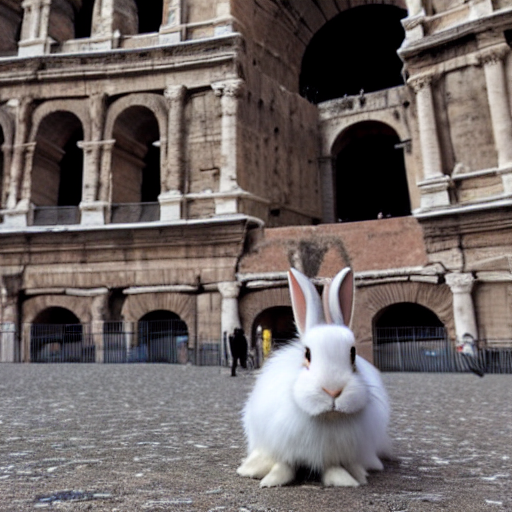

In [ ]:
# generating an image from some text is as easy as:
prompt = "a photo of a rabbit in front of the colosseum"
image = pipe(prompt, generator=torch.Generator().manual_seed(0)).images[0]
image

## References

[1] Dinh, L., Sohl-Dickstein, J., and Bengio, S. (2017). “Density estimation using Real NVP,” In: 5th International Conference on Learning Representations, ICLR 2017. [Link](https://arxiv.org/abs/1605.08803)

[2] Kingma, D. P., and Dhariwal, P. (2018). “Glow: Generative Flow with Invertible 1x1 Convolutions,” In: Advances in Neural Information Processing Systems, vol. 31, pp. 10215--10224. [Link](http://papers.nips.cc/paper/8224-glow-generative-flow-with-invertible-1x1-convolutions.pdf)

[3] Ho, J., Chen, X., Srinivas, A., Duan, Y., and Abbeel, P. (2019). “Flow++: Improving Flow-Based Generative Models with Variational Dequantization and Architecture Design,” in Proceedings of the 36th International Conference on Machine Learning, vol. 97, pp. 2722–2730. [Link](https://arxiv.org/abs/1902.00275)

[4] Durkan, C., Bekasov, A., Murray, I., and Papamakarios, G. (2019). “Neural Spline Flows,” In: Advances in Neural Information Processing Systems, pp. 7509–7520. [Link](http://papers.neurips.cc/paper/8969-neural-spline-flows.pdf)

[5] Hoogeboom, E., Cohen, T. S., and Tomczak, J. M. (2020). “Learning Discrete Distributions by Dequantization,” arXiv preprint arXiv2001.11235v1. [Link](https://arxiv.org/abs/2001.11235)

[6] Lippe, P., and Gavves, E. (2021). “Categorical Normalizing Flows via Continuous Transformations,” In: International Conference on Learning Representations, ICLR 2021. [Link](https://openreview.net/pdf?id=-GLNZeVDuik)

[7] Kruse, J., Detommaso, G., Köthe, U., & Scheichl, R. (2021, May). Hint: Hierarchical invertible neural transport for density estimation and bayesian inference. In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 35, No. 9, pp. 8191-8199). [Link](https://arxiv.org/abs/1905.10687)

---

# Credits

Big thanks to [Phillip Lippe](https://phlippe.github.io), tutorial adapted from [here](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html).

---